# Clusterization for building recommendation system

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import typing as tp

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, KMeans
from scipy.sparse import coo_matrix
from src.utils import rec_imaging

## Data preparation

In [5]:
interactions = pd.read_csv("data/BX-Book-Ratings.csv", sep=";", encoding="unicode-escape")
books = pd.read_csv("data/BX-Books.csv", low_memory=False)
users = pd.read_csv("data/BX-Users.csv", sep=";", encoding="unicode-escape")

Merge tables, so that it'll be possible to get item name and image url of item to view it later.

In [6]:
interactions = (
    interactions
    .merge(
        books[["ISBN", "Book-Title", "Image-URL-M"]],
        how="left",
        on="ISBN"
    )
)

Rename columns for convenience.

In [7]:
interactions = interactions.rename(
    columns={
        "User-ID": "user_id",
        "ISBN": "item_id",
        "Book-Rating": "score",
        "Book-Title": "item_name",
        "Image-URL-M": "image_url"
    }
)

Preprocess interactions.

In [8]:
interactions = interactions[interactions["item_name"].notna()]
interactions = interactions[interactions["score"] > 0]
le = LabelEncoder()
interactions["item_id"] = le.fit_transform(interactions["item_id"])
interactions["user_id"] = le.fit_transform(interactions["user_id"])

In [9]:
interactions = (
    interactions
    .groupby(["user_id", "item_id"])
    .agg({
        "score": "sum",
        "item_name": "first",
        "image_url": "first"
    })
    .reset_index()
)

## Model

In [35]:
class Clusterization:
    def __init__(
        self,
        interactions_df: pd.DataFrame,
    ) -> None:
        self.content_dict = {}
        self.interactions_df = interactions_df

        # Fill dict with content
        for i, j, k in self.interactions_df[["item_id", "item_name", "image_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = {
                "name": j,
                "image_url": k
            }

        # Create matrix in COO format
        self.coo_rates: coo_matrix = coo_matrix(
            (
                self.interactions_df["score"],
                (self.interactions_df["user_id"], self.interactions_df["item_id"])
            ),
            shape=(len(set(self.interactions_df["user_id"])), len(set(self.interactions_df["item_id"])))
        )

    def dbscan(self) -> None:
        """Clusters users with DBSCAN method."""
        pass

    def kmeans(
        self,
        n_clusters: int = 10,
        init: str = "k-means++"
    ) -> None:
        """Clusters users with K-Means method."""
        
        self.cluster_method = KMeans(
            n_clusters=n_clusters,
            init=init,
            verbose=0
        )

        user_id_to_cluster_map = self.cluster_method.fit_predict(self.coo_rates)

        self.interactions_df["cluster_id"] = self.interactions_df["user_id"].map(lambda id: user_id_to_cluster_map[id])

    def get_recs_for_user(
        self,
        user_id: int
    ) -> None:
        cluster_id = (
            self.interactions_df
            [self.interactions_df["user_id"] == user_id]
            ["cluster_id"].iloc[0]
        )

        cluster_interactions_df = (
            self.interactions_df
            [self.interactions_df["cluster_id"] == cluster_id]
        )

        num_of_users_in_cluster = len(cluster_interactions_df["user_id"].unique())

        rates = (
            cluster_interactions_df
            .groupby("item_id")
            ["score"]
            .sum()
            .map(lambda x: x / num_of_users_in_cluster)
            .sort_values(ascending=False)
        )

        top_recs = rates[:10].index.to_list()
        measure = rates[:10].values
        self.get_rec(cluster_id, top_recs, measure)

    def get_recs_for_cluster(
        self,
        cluster_id: int
    ) -> None:
        cluster_interactions_df = (
            self.interactions_df
            [self.interactions_df["cluster_id"] == cluster_id]
        )

        num_of_users_in_cluster = len(cluster_interactions_df["user_id"].unique())

        rates = (
            cluster_interactions_df
            .groupby("item_id")
            ["score"]
            .sum()
            .map(lambda x: x / num_of_users_in_cluster)
            .sort_values(ascending=False)
        )

        top_recs = rates[:10].index.to_list()
        measure = rates[:10].values
        self.get_rec(cluster_id, top_recs, measure)

    def get_rec(
        self,
        cluster: int,
        recs: tp.List[int],
        measure: tp.List[float]
    ) -> None:
        print(f"Top recommendations for cluster: {cluster}")
        rec_imaging(recs, self.content_dict, measure)

In [36]:
model = Clusterization(interactions)

In [37]:
model.kmeans()

Top recommendations for cluster: 8


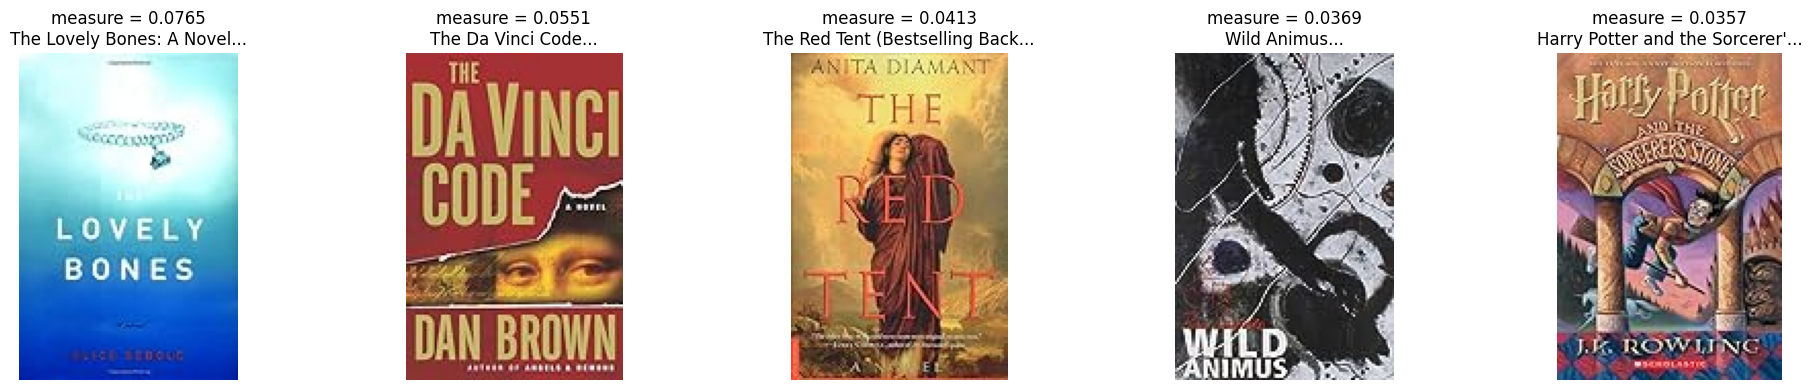

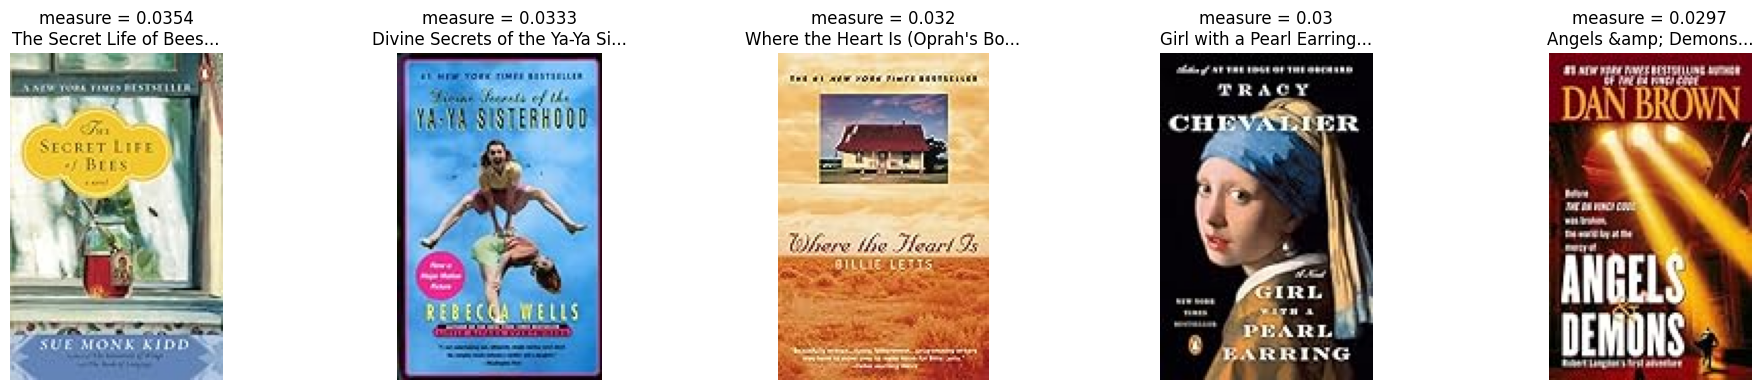

In [38]:
model.get_recs_for_user(200)

Top recommendations for cluster: 0


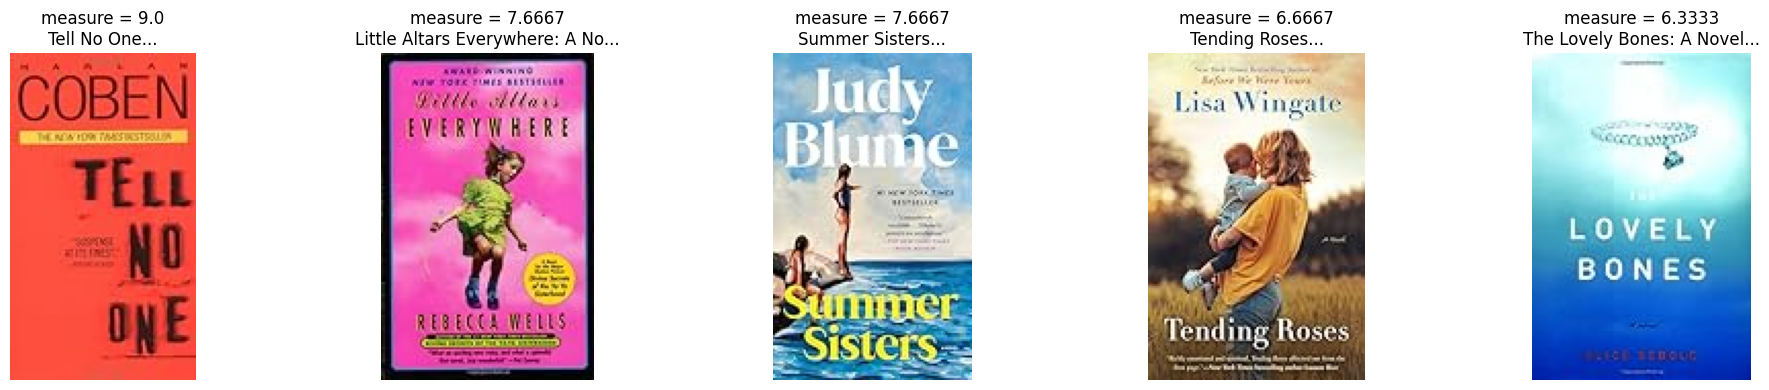

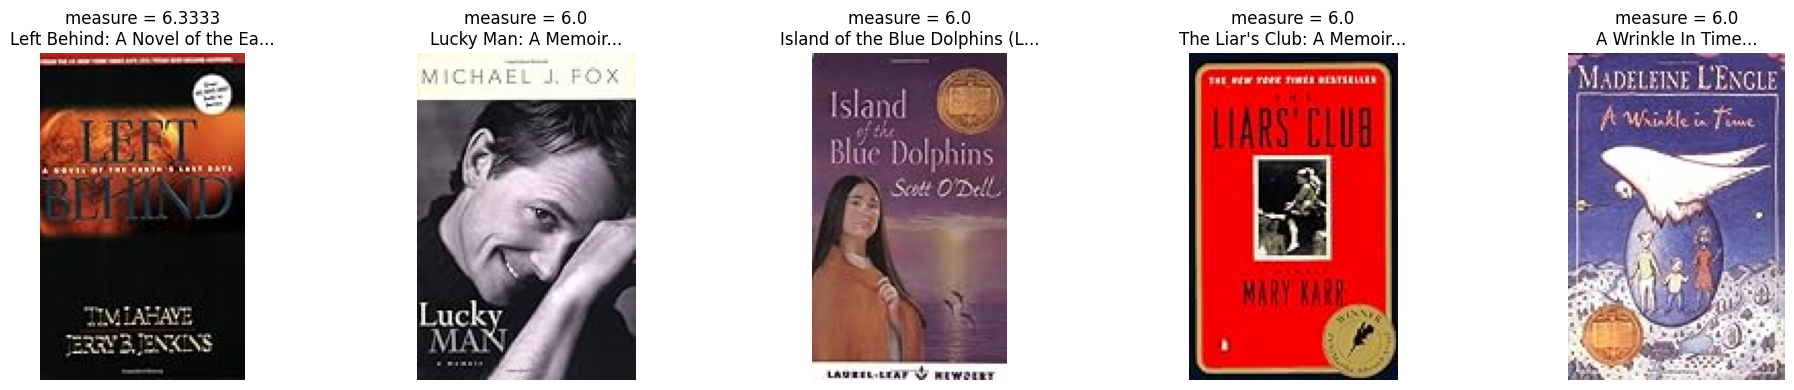

In [40]:
model.get_recs_for_cluster(0)